# Exploratory Data Analysis


In this Notebook we perform exploratory data analysis (EDA) on the provided internal dataset from the fire department.
The csv-files are accessed via the database tables from the Dagster ETL processes.

In [2]:
import duckdb
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from shapely.geometry import Point
import seaborn as sns
import folium
import windrose

### Create Database Connection

In [3]:
%load_ext sql
conn = duckdb.connect(database="../dsp-dagster/data_systems_project.duckdb")
%sql conn --alias duckdb
# %sql SHOW ALL TABLES;

Tip: You may define configurations in /home/workspaces/DSP-compose/pyproject.toml or /root/.jupysql/config.

##### Retrieve Tables as Pandas DataFrame

In [4]:
storm_incidents = conn.execute(
    """
    SELECT * FROM public.storm_incidents
    """
).df()

storm_deployments = conn.execute(
    """
    SELECT * FROM public.storm_deployments 
    """
).df()

fire_stations_and_vehicles = conn.execute(
    """
    SELECT * FROM public.fire_stations_and_vehicles
    """
).df()

service_areas = conn.execute(
    """
    SELECT * FROM public.service_areas
    """
).df()

knmi_weather_data = conn.execute(
    """
    SELECT * FROM public.knmi_weather_data
    """
).df()

## Internal Data

### Storm Incidents

In [39]:
storm_incidents.head(n=10)

,Incident_ID,Date,Incident_Starttime,Incident_Endtime,Incident_Duration,Incident_Priority,Service_Area,Municipality,Damage_Type,LON,LAT
0,511,2018-09-07,08:25:18,10:00:56,0 days 01:35:38,2.0,Amstelveen,Amstelveen,Tree,4.838685,52.281552
1,738,2018-09-10,16:46:38,18:00:55,0 days 01:14:17,2.0,Victor,Amsterdam,Tree,4.930968,52.359724
2,739,2018-09-10,17:11:20,18:01:00,0 days 00:49:40,2.0,Dirk,Amsterdam,Building,4.898818,52.357071
3,1335,2018-09-18,19:17:33,20:41:29,0 days 01:23:56,2.0,Zebra,Amsterdam,"Fence, Road signs, Scaffolding",4.960809,52.392155
4,1493,2018-09-21,06:59:05,08:21:25,0 days 01:22:20,2.0,Amstelveen,Amstelveen,Tree,4.879741,52.301365
5,1502,2018-09-21,08:29:22,10:06:43,0 days 01:37:21,2.0,Dirk,Amsterdam,Building,4.870656,52.355189
6,1502,2018-09-21,08:29:22,10:06:43,0 days 01:37:21,2.0,Dirk,Amsterdam,Tree,4.870656,52.355189
7,1507,2018-09-21,09:25:55,11:43:54,0 days 02:17:59,2.0,Teunis,Amsterdam,Tree,4.832333,52.380748
8,1508,2018-09-21,09:34:54,12:54:46,0 days 03:19:52,5.0,Nico,Amsterdam,"Fence, Road signs, Scaffolding",4.905491,52.365735
9,1544,2018-09-21,17:03:15,18:32:00,0 days 01:28:45,2.0,Anton,Amsterdam,"Fence, Road signs, Scaffolding",4.961133,52.306432


In [22]:
print(storm_incidents.dtypes)
storm_incidents.describe(include="all")

Incident_ID                    int64
Date                  datetime64[us]
Incident_Starttime            object
Incident_Endtime              object
Incident_Duration             object
Incident_Priority            float64
Service_Area                  object
Municipality                  object
Damage_Type                   object
LON                          float64
LAT                          float64
dtype: object


,Incident_ID,Date,Incident_Starttime,Incident_Endtime,Incident_Duration,Incident_Priority,Service_Area,Municipality,Damage_Type,LON,LAT
count,5737.000000,5737,5737,5737,5737,5734.000000,5737,5736,5737,5737.000000,5737.000000
unique,NaN,NaN,4851,4892,4030,NaN,23,12,4,NaN,NaN
top,NaN,NaN,09:12:04,15:37:24,00:00:00,NaN,Hendrik,Amsterdam,Tree,NaN,NaN
freq,NaN,NaN,6,5,79,NaN,770,3818,2425,NaN,NaN
mean,306466.407007,2018-11-10 16:43:00.303294,NaN,NaN,NaN,2.618242,NaN,NaN,NaN,4.884219,52.351250
min,511.000000,2005-04-07 00:00:00,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,4.717010,52.215112
25%,283008.000000,2017-10-07 00:00:00,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,4.853749,52.339662
50%,341929.000000,2020-02-21 00:00:00,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,4.884772,52.358977
75%,393994.000000,2022-02-19 00:00:00,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,4.915111,52.375754
max,443486.000000,2023-11-02 00:00:00,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,5.076108,52.428050


Distribution of Damage Types in Storm incidents

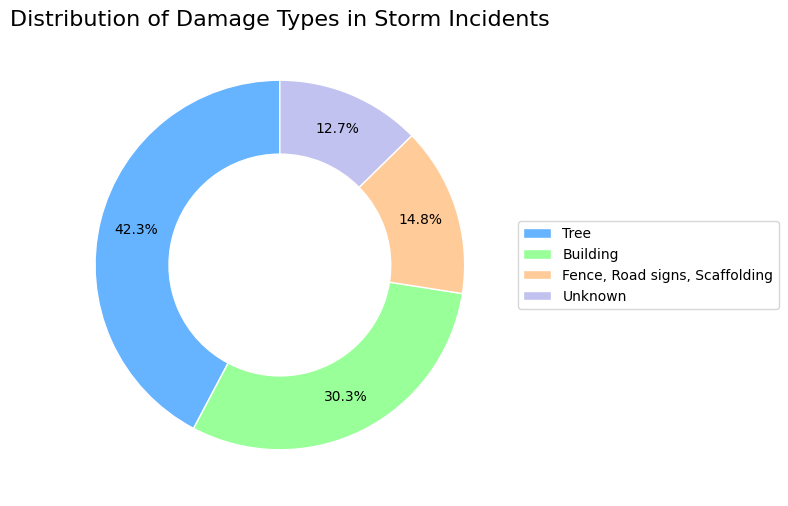

In [95]:
# Extract damage type column
damage_type = storm_incidents["Damage_Type"].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(
    damage_type,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#66b3ff", "#99ff99", "#ffcc99", "#c2c2f0"],
    wedgeprops=dict(width=0.4, edgecolor="w"),
    pctdistance=0.8,
)

# Add a title and legend
plt.title("Distribution of Damage Types in Storm Incidents", fontsize=16)
plt.legend(
    ["Tree", "Building", "Fence, Road signs, Scaffolding", "Unknown"],
    bbox_to_anchor=(1, 0.5),
    loc="center left",
)

# Display the pie chart
plt.show()

Duration of Incidents

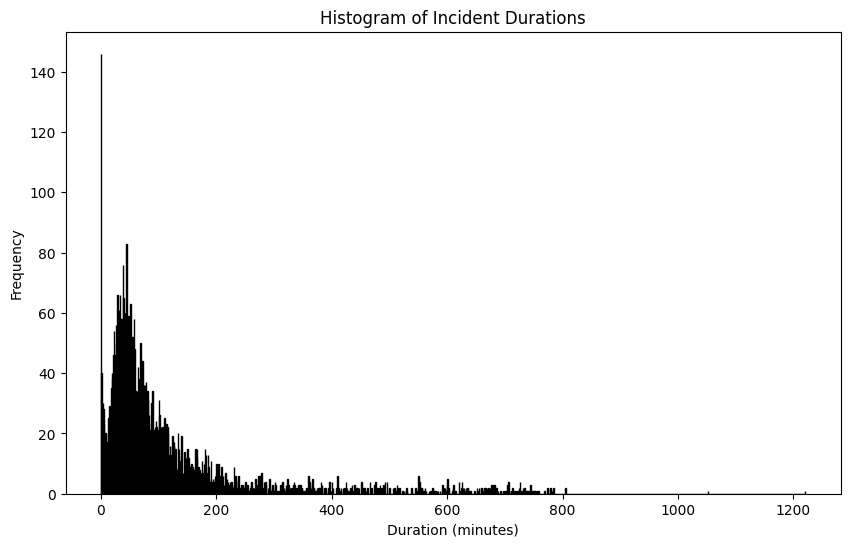

Incidents that have no duration: 79
The frequency of the first bin is: 146.0


In [118]:
# Convert the "Incident_Duration" column to timedelta
storm_incidents["Incident_Duration"] = pd.to_timedelta(
    storm_incidents["Incident_Duration"]
)

# Calculate the number of bins based on the maximum duration and desired bin width
max_duration_seconds = storm_incidents["Incident_Duration"].max().total_seconds()
desired_bin_width = 60
num_bins = int(np.ceil(max_duration_seconds / desired_bin_width))

# Plot histogram for Incident Durations with specified bin width
plt.figure(figsize=(10, 6))
hist, bin_edges, _ = plt.hist(
    storm_incidents["Incident_Duration"].dt.total_seconds() / 60,
    bins=num_bins,
    color="black",
    edgecolor="black",
)

plt.title("Histogram of Incident Durations")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")

plt.show()

# Calculate zero duration incidents
zero_duration = sum(storm_incidents["Incident_Duration"] == "00:00:00")
print(f"Incidents that have no duration: {zero_duration}")

# Check the frequency of the first bin
first_bin_frequency = hist[0]
print(f"The frequency of the first bin is: {first_bin_frequency}")

In [38]:
# Convert the "Incident_Duration" column to timedelta
storm_incidents["Incident_Duration"] = pd.to_timedelta(
    storm_incidents["Incident_Duration"]
)

# Calculate the mean duration
mean_duration = storm_incidents["Incident_Duration"].mean()

# Print the result
print("Mean Duration of Incidents:", mean_duration)

Mean Duration of Incidents: 0 days 01:52:40.161582708


Histogram of incident start and end times

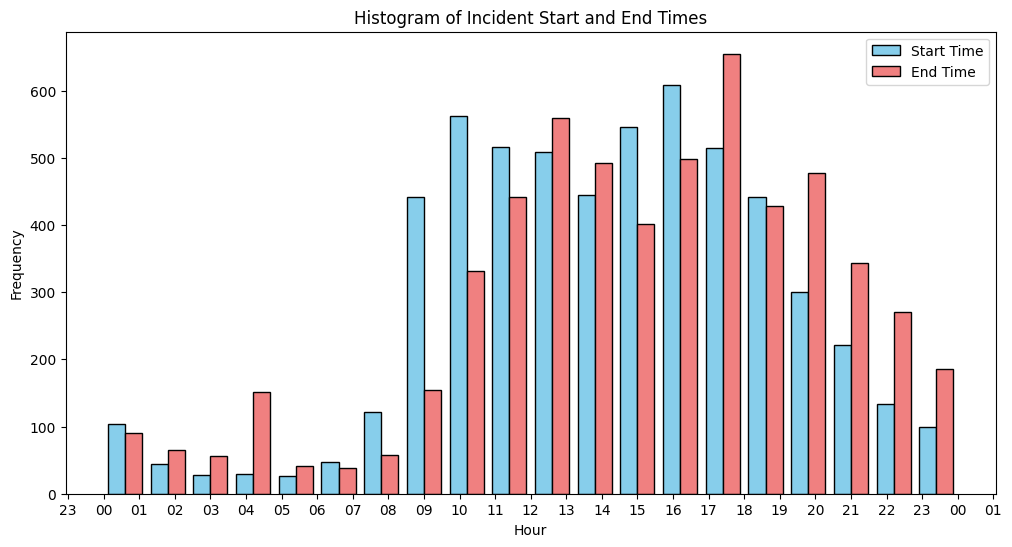

In [52]:
# Convert the "Incident_Starttime" and "Incident_Endtime" columns to datetime
storm_incidents["Incident_Starttime"] = pd.to_datetime(
    storm_incidents["Incident_Starttime"]
)
storm_incidents["Incident_Endtime"] = pd.to_datetime(
    storm_incidents["Incident_Endtime"]
)

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for Incident Start and End Time
plt.hist(
    [storm_incidents["Incident_Starttime"], storm_incidents["Incident_Endtime"]],
    bins=20,
    color=["skyblue", "lightcoral"],
    edgecolor="black",
    label=["Start Time", "End Time"],
)
plt.title("Histogram of Incident Start and End Times")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

# Format x-axis as datetime with hourly ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))

plt.show()

Location of Incidents

/tmp/ipykernel_1580/201175219.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  amsterdam_boundary = gpd.read_file(gpd.datasets.get_path("naturalearth_cities"))
/tmp/ipykernel_1580/201175219.py:28: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/tmp/ipykernel_1580/201175219.py:53: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  geo_df[geo_df["Municipality"] == municipality].plot(


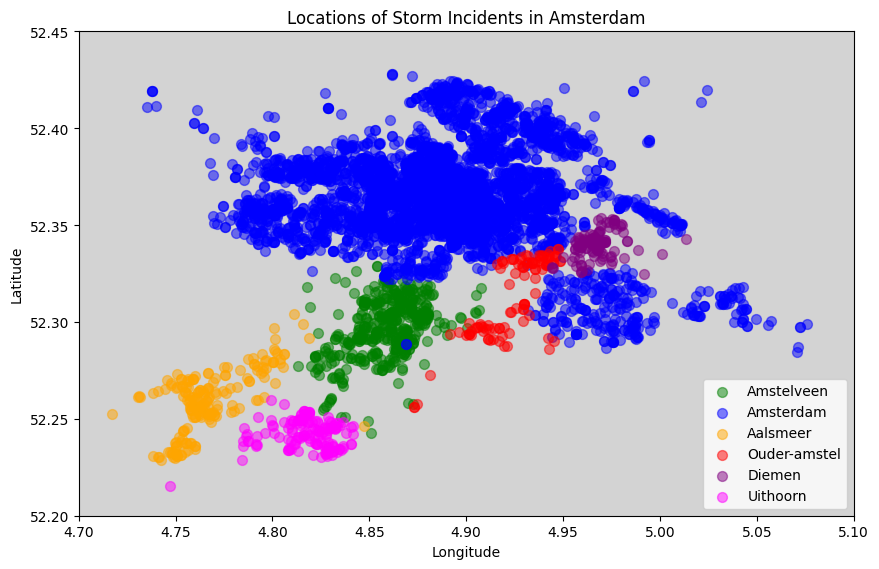

In [92]:
# Create a GeoDataFrame with the incident data
geometry = [Point(xy) for xy in zip(storm_incidents["LON"], storm_incidents["LAT"])]
geo_df = gpd.GeoDataFrame(storm_incidents, geometry=geometry)

# Obtain the bounding box for Amsterdam
amsterdam_bbox = (
    4.7,
    52.2,
    5.1,
    52.45,
)

# Load a GeoDataFrame for the boundaries of Amsterdam from geopandas
amsterdam_boundary = gpd.read_file(gpd.datasets.get_path("naturalearth_cities"))

# Filter Amsterdam from the world cities dataset
amsterdam_boundary = amsterdam_boundary[amsterdam_boundary["name"] == "Amsterdam"]

# Convert "Municipality" column to lowercase to ensure consistent capitalization
geo_df["Municipality"] = geo_df["Municipality"].str.capitalize()

# World map as a backdrop
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Define standard colors for each municipality
municipality_colors = {
    "Amstelveen": "green",
    "Amsterdam": "blue",
    "Aalsmeer": "orange",
    "Ouder-amstel": "red",
    "Diemen": "purple",
    "Uithoorn": "magenta",
    None: "lightgray",  # For incidents with no specified municipality
}

# Plot the incidents on the map, zoomed in to Amsterdam, with Amsterdam's boundaries in the background
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(amsterdam_bbox[0], amsterdam_bbox[2])
ax.set_ylim(amsterdam_bbox[1], amsterdam_bbox[3])

world.plot(ax=ax, color="lightgray")
amsterdam_boundary.plot(
    ax=ax, color="none", edgecolor="blue", linewidth=2
)  # Amsterdam's boundaries

# Plot incidents with different colors for each municipality
for municipality, color in municipality_colors.items():
    geo_df[geo_df["Municipality"] == municipality].plot(
        ax=ax, marker="o", color=color, markersize=50, label=municipality, alpha=0.5
    )

plt.title("Locations of Storm Incidents in Amsterdam")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

plt.show()

### Storm Deployment

In [121]:
storm_deployments.head(n=10)

,Deployment_ID,Incident_ID,Vehicle_Type,Vehicle_Role,Fire_Station,Fire_Station_Service_Status,Driving_Time_To_Incident
0,1,511,TS,TS,Amstelveen,Professional,708
1,2,511,AL,RV,Amstelveen,Professional,786
2,3,738,TS,TS,Victor,Professional,116
3,4,738,AL,RV,Victor,Professional,114
4,5,739,AL,RV,Dirk,Professional,438
5,6,1493,TS,TS,Amstelveen Vrijwillig,Volunteer,356
6,7,1502,TS,TS,Dirk,Professional,346
7,8,1507,TS,TS,Teunis,Professional,633
8,9,1507,AL,RV,Teunis,Professional,794
9,10,1544,AL,RV,Anton,Professional,437


In [125]:
print(storm_deployments.dtypes)
storm_deployments.describe(include="all")

Deployment_ID                   int64
Incident_ID                     int64
Vehicle_Type                   object
Vehicle_Role                   object
Fire_Station                   object
Fire_Station_Service_Status    object
Driving_Time_To_Incident       object
dtype: object


,Deployment_ID,Incident_ID,Vehicle_Type,Vehicle_Role,Fire_Station,Fire_Station_Service_Status,Driving_Time_To_Incident
count,5193.000000,5193.000000,5193,5193,5193,5193,5193
unique,NaN,NaN,10,10,20,2,1102
top,NaN,NaN,TS,TS,Hendrik,Professional,NULL
freq,NaN,NaN,2989,2989,671,4493,756
mean,2597.000000,273154.601194,NaN,NaN,NaN,NaN,NaN
std,1499.234305,132632.539300,NaN,NaN,NaN,NaN,NaN
min,1.000000,511.000000,NaN,NaN,NaN,NaN,NaN
25%,1299.000000,117019.000000,NaN,NaN,NaN,NaN,NaN
50%,2597.000000,321585.000000,NaN,NaN,NaN,NaN,NaN
75%,3895.000000,391349.000000,NaN,NaN,NaN,NaN,NaN


Station Service Status

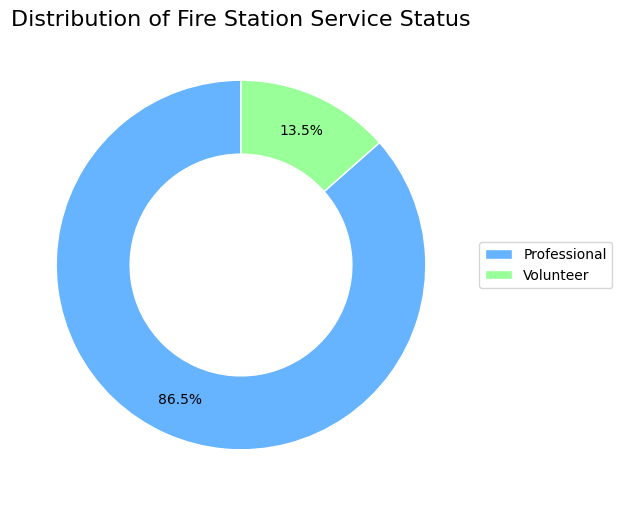

In [130]:
fire_station_service_status = storm_deployments[
    "Fire_Station_Service_Status"
].value_counts()

# Create a pie chart for the service status of fire stations
plt.figure(figsize=(10, 6))
plt.pie(
    fire_station_service_status,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#66b3ff", "#99ff99"],
    wedgeprops=dict(width=0.4, edgecolor="w"),
    pctdistance=0.8,
)

# Add a title and legend
plt.title("Distribution of Fire Station Service Status", fontsize=16)
plt.legend(
    fire_station_service_status.index,
    bbox_to_anchor=(1, 0.5),
    loc="center left",
)

# Display the pie chart
plt.show()

Driving Time to Incidents

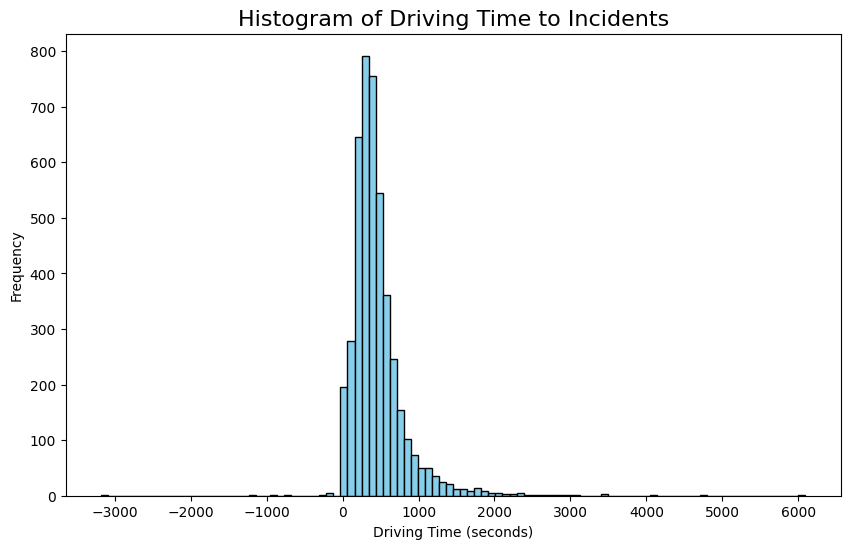

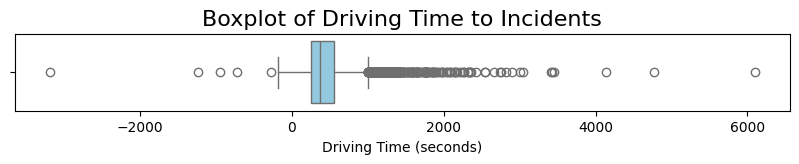

Number of NaN values in 'Driving_Time_To_Incident': 756
The average driving time is: 451.1020960108181


In [166]:
# Convert "Driving_Time_To_Incident" to numeric
driving_time_to_incident = pd.to_numeric(
    storm_deployments["Driving_Time_To_Incident"], errors="coerce"
)

# Create histogram for driving time to incidents
plt.figure(figsize=(10, 6))
plt.hist(driving_time_to_incident, color="skyblue", edgecolor="black", bins=100)

# Add title and labels
plt.title("Histogram of Driving Time to Incidents", fontsize=16)
plt.xlabel("Driving Time (seconds)")
plt.ylabel("Frequency")
plt.xticks(ticks=range(-3000, int(driving_time_to_incident.max()), 1000))

# Show the histogram
plt.show()

# Create boxplot for driving time to incidents
plt.figure(figsize=(10, 1))
sns.boxplot(x=driving_time_to_incident, color="skyblue")

# Add title and labels
plt.title("Boxplot of Driving Time to Incidents", fontsize=16)
plt.xlabel("Driving Time (seconds)")

# Show the boxplot
plt.show()

nan_count = driving_time_to_incident.isna().sum()
print(f"Number of NaN values in 'Driving_Time_To_Incident': {nan_count}")

avg_driving_time = driving_time_to_incident.mean()
print(f"The average driving time is: {avg_driving_time}")

### Fire Stations and Vehicles

In [204]:
fire_stations_and_vehicles.head(n=10)

,Fire_Station,Vehicle,Vehicle_Type
0,Aalsmeer,Tankautospuit,TS
1,Aalsmeer,Haakarmvoertuig met kraan,RV
2,Aalsmeer,Haakarmvoertuig,RV
3,Aalsmeer,Tankautospuit,TS
4,Amstelveen,Waterongevallenvoertuig,WO
5,Amstelveen,Tankautospuit,TS
6,Amstelveen,Autoladder,AL
7,Amstelveen,HV met kraan,RV
8,Amstelveen Vrijwillig,Tankautospuit,TS
9,Amstelveen Vrijwillig,Schuimblusvoertuig,TS


In [205]:
print(fire_stations_and_vehicles.dtypes)
fire_stations_and_vehicles.describe(include="all")

Fire_Station    object
Vehicle         object
Vehicle_Type    object
dtype: object


,Fire_Station,Vehicle,Vehicle_Type
count,60,60,60
unique,20,14,4
top,GBA,Tankautospuit,TS
freq,9,25,30


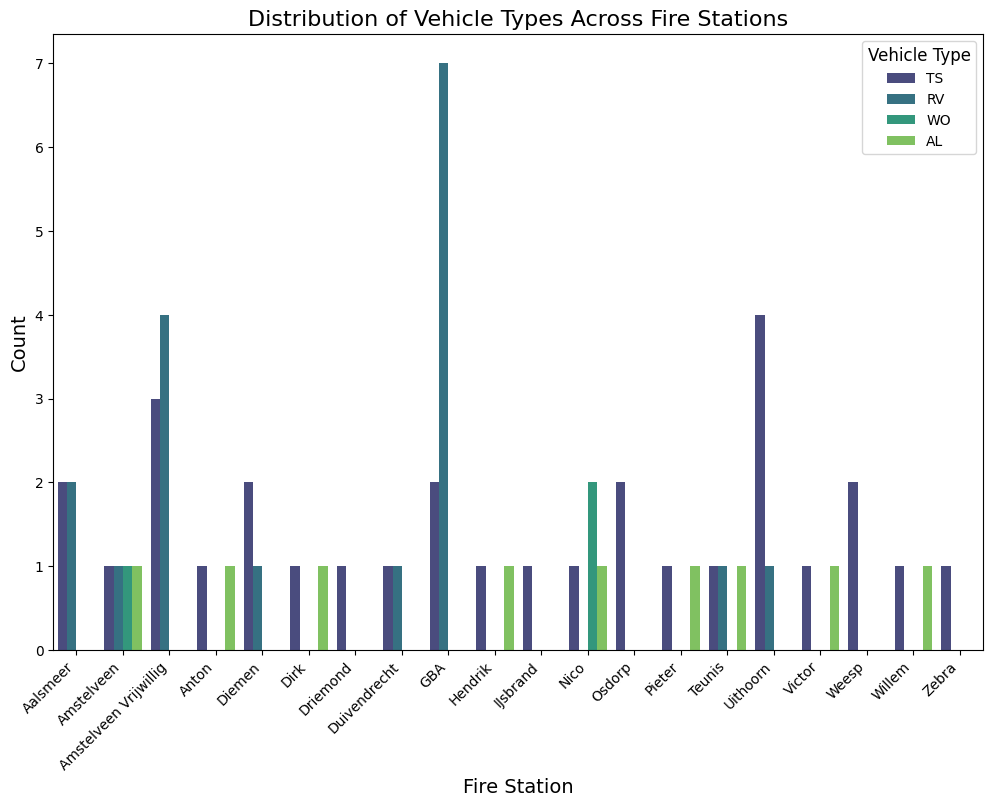

In [200]:
# Create a bar chart of vehicle types for each fire station
plt.figure(figsize=(12, 8))
sns.countplot(
    x="Fire_Station",
    hue="Vehicle_Type",
    data=fire_stations_and_vehicles,
    palette="viridis",
)

# Add title and labels
plt.title("Distribution of Vehicle Types Across Fire Stations", fontsize=16)
plt.xlabel("Fire Station", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Display the legend
plt.legend(title="Vehicle Type", title_fontsize="12")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()

### Service Areas

In [206]:
service_areas.head(n=10)

,H_Verzorgingsgebied_ID,Verzorgingsgebied,LAT,LON,geometry
0,60,Aalsmeer,52.262846,4.764090,POLYGON ((110373.6000000000058208 468913.29999...
1,62,Amstelveen,52.306531,4.888029,MULTIPOLYGON (((115222.6999999999970896 482926...
2,64,Anton,52.308747,4.980264,MULTIPOLYGON (((128942.6999999999970896 482813...
3,70,Diemen,52.341314,4.964931,MULTIPOLYGON (((124486.0000000000000000 483319...
4,71,Dirk,52.360768,4.886359,MULTIPOLYGON (((121226.5000000000000000 483359...
5,72,Driemond,52.316452,5.020421,MULTIPOLYGON (((129745.6000000000058208 482648...
6,73,Duivendrecht,52.333488,4.944756,MULTIPOLYGON (((124668.0000000000000000 483362...
7,74,GBA,52.399355,4.798441,MULTIPOLYGON (((118041.6999999999970896 489944...
8,79,Hendrik,52.375786,4.875513,POLYGON ((119210.8000000000029104 485853.90000...
9,81,IJsbrand,52.406521,4.889798,MULTIPOLYGON (((120493.0000000000000000 493121...


In [207]:
print(service_areas.dtypes)
service_areas.describe(include="all")

H_Verzorgingsgebied_ID      int64
Verzorgingsgebied          object
LAT                       float64
LON                       float64
geometry                   object
dtype: object


,H_Verzorgingsgebied_ID,Verzorgingsgebied,LAT,LON,geometry
count,19.000000,19,19.000000,19.000000,19
unique,NaN,19,NaN,NaN,19
top,NaN,Aalsmeer,NaN,NaN,POLYGON ((110373.6000000000058208 468913.29999...
freq,NaN,1,NaN,NaN,1
mean,87.578947,NaN,52.344579,4.900174,NaN
std,19.861509,NaN,0.044862,0.075496,NaN
min,60.000000,NaN,52.246243,4.764090,NaN
25%,71.500000,NaN,52.312600,4.856302,NaN
50%,81.000000,NaN,52.353822,4.889798,NaN
75%,107.500000,NaN,52.371685,4.948731,NaN


Create map with service areas

In [241]:
# Create map of Amsterdam
amsterdam_map = folium.Map(
    location=[52.3676, 4.9041], zoom_start=12, tiles="CartoDB positron"
)

# Display the map
amsterdam_map

## External Data

### KNMI Weather Data

In [5]:
knmi_weather_data.head(n=10)

,station_code,date,hour,DD,FH,FF,FX,T,T10N,TD,...,VV,N,U,WW,IX,M,R,S,O,Y
0,240,2005-01-01T00:00:00.000Z,1,260,40,30,60,68,NaN,57,...,57.0,8.0,93,10.0,7,0.0,0.0,0.0,0.0,0.0
1,240,2005-01-01T00:00:00.000Z,2,230,30,30,60,65,NaN,52,...,58.0,8.0,91,10.0,7,0.0,0.0,0.0,0.0,0.0
2,240,2005-01-01T00:00:00.000Z,3,230,40,30,50,43,NaN,34,...,40.0,1.0,94,10.0,7,0.0,0.0,0.0,0.0,0.0
3,240,2005-01-01T00:00:00.000Z,4,220,40,40,50,38,NaN,32,...,12.0,0.0,96,10.0,7,0.0,0.0,0.0,0.0,0.0
4,240,2005-01-01T00:00:00.000Z,5,230,40,40,50,38,NaN,34,...,14.0,3.0,97,10.0,7,0.0,0.0,0.0,0.0,0.0
5,240,2005-01-01T00:00:00.000Z,6,200,40,40,50,32,21.0,29,...,25.0,0.0,98,10.0,7,0.0,0.0,0.0,0.0,0.0
6,240,2005-01-01T00:00:00.000Z,7,200,40,50,60,40,NaN,38,...,14.0,3.0,99,20.0,7,1.0,0.0,0.0,0.0,0.0
7,240,2005-01-01T00:00:00.000Z,8,200,50,50,70,49,NaN,46,...,35.0,8.0,98,10.0,7,0.0,0.0,0.0,0.0,0.0
8,240,2005-01-01T00:00:00.000Z,9,200,50,50,70,55,NaN,51,...,41.0,8.0,97,10.0,7,0.0,0.0,0.0,0.0,0.0
9,240,2005-01-01T00:00:00.000Z,10,200,50,40,60,61,NaN,55,...,57.0,8.0,96,10.0,7,0.0,0.0,0.0,0.0,0.0


In [6]:
print(knmi_weather_data.dtypes)
knmi_weather_data.describe(include="all")

station_code      int64
date             object
hour              int64
DD                int64
FH                int64
FF                int64
FX                int64
T                 int64
T10N            float64
TD                int64
SQ                int64
Q                 int64
DR                int64
RH                int64
P                 int64
VV              float64
N               float64
U                 int64
WW              float64
IX                int64
M               float64
R               float64
S               float64
O               float64
Y               float64
dtype: object


,station_code,date,hour,DD,FH,FF,FX,T,T10N,TD,...,VV,N,U,WW,IX,M,R,S,O,Y
count,167688.0,167688,167688.000000,167688.000000,167688.000000,167688.000000,167688.000000,167688.000000,27922.000000,167688.000000,...,167682.000000,167646.000000,167688.000000,67448.000000,167688.000000,167681.000000,167681.000000,167681.000000,167681.000000,167681.000000
unique,NaN,6949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2014-11-10T00:00:00.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,240.0,NaN,12.500000,195.991067,49.091885,49.196603,78.309301,110.222270,82.286190,74.611195,...,64.917719,5.578379,80.079928,29.936766,5.804661,0.020348,0.203690,0.010073,0.009530,0.004491
std,0.0,NaN,6.922207,115.878318,27.050476,27.518218,40.411804,65.185935,64.878764,55.952453,...,14.580872,3.292568,14.072775,26.002879,0.980714,0.141189,0.402743,0.099856,0.097156,0.066862
min,240.0,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,-178.000000,-215.000000,-192.000000,...,0.000000,0.000000,20.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,240.0,NaN,6.750000,120.000000,30.000000,30.000000,50.000000,64.000000,37.000000,35.000000,...,60.000000,2.000000,71.000000,10.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,240.0,NaN,12.500000,200.000000,40.000000,40.000000,70.000000,109.000000,82.000000,77.000000,...,68.000000,8.000000,83.000000,23.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,240.0,NaN,18.250000,260.000000,60.000000,60.000000,100.000000,158.000000,131.000000,118.000000,...,75.000000,8.000000,91.000000,51.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Data manipulation

In [34]:
# Convert the 'date' column to datetime type if it's not already in datetime format
knmi_weather_data["date"] = pd.to_datetime(knmi_weather_data["date"])

# Convert wind speed to m/s
knmi_weather_data["FX_m/s"] = knmi_weather_data["FX"] * 0.1

Highest Wind Speed Over Time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


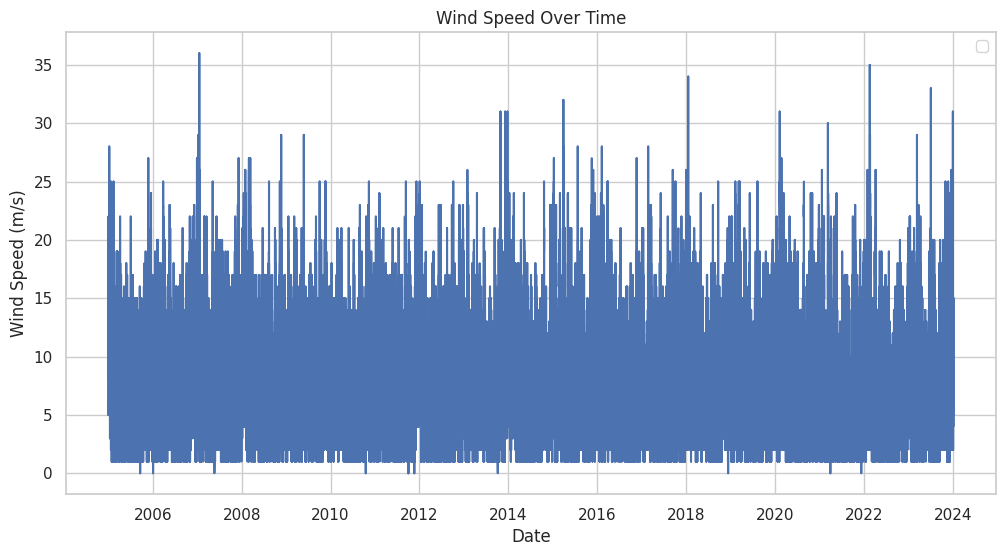

In [35]:
# Plotting wind speed
plt.figure(figsize=(12, 6))
plt.plot(knmi_weather_data["date"], knmi_weather_data["FX_m/s"])
plt.title("Wind Speed Over Time")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# Find the maximum wind gust value
max_wind_gust = knmi_weather_data["FX_m/s"].max()

# Find the corresponding row where the maximum wind gust occurred
max_wind_gust_row = knmi_weather_data[knmi_weather_data["FX_m/s"] == max_wind_gust]

# Extract the date and wind direction from the row
date_of_max_wind_gust = max_wind_gust_row[
    "date"
]  # Replace with your actual date column name
direction_of_max_wind_gust = max_wind_gust_row["DD"]

# Print the results
print("Maximum Wind Gust:")
print(f"Date: {date_of_max_wind_gust.iloc[0]}")
print(f"Direction: {direction_of_max_wind_gust.iloc[0]} degrees")
print(f"Wind Gust Speed: {max_wind_gust} m/s")

Maximum Wind Gust:
Date: 2007-01-18 00:00:00+00:00
Direction: 230 degrees
Wind Gust Speed: 36.0 m/s


Highest Wind Speed Averaged by Direction

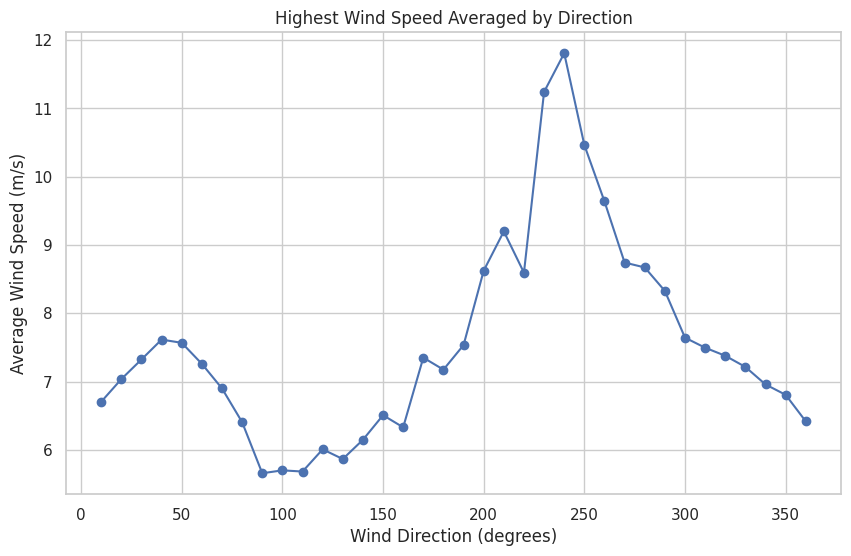

In [62]:
# Calculate the average wind speed for each direction
average_wind_speed = knmi_weather_data.groupby("DD")["FX_m/s"].mean().reset_index()

# Drop rows with index 0 and 37
average_wind_speed = average_wind_speed.drop([0, 37])

# Reindex the DataFrame
average_wind_speed = average_wind_speed.reset_index(drop=True)

# Print results
# print(average_wind_speed)

# Plot the average wind speed for each direction
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(
    average_wind_speed["DD"], average_wind_speed["FX_m/s"], marker="o", linestyle="-"
)
plt.title("Highest Wind Speed Averaged by Direction")
plt.xlabel("Wind Direction (degrees)")
plt.ylabel("Average Wind Speed (m/s)")
plt.grid(True)
plt.show()

Windrose - Highest Wind Speed by Direction
- Wind Speed: colour
- Wind Direction: angle
- Frequency: length of bar

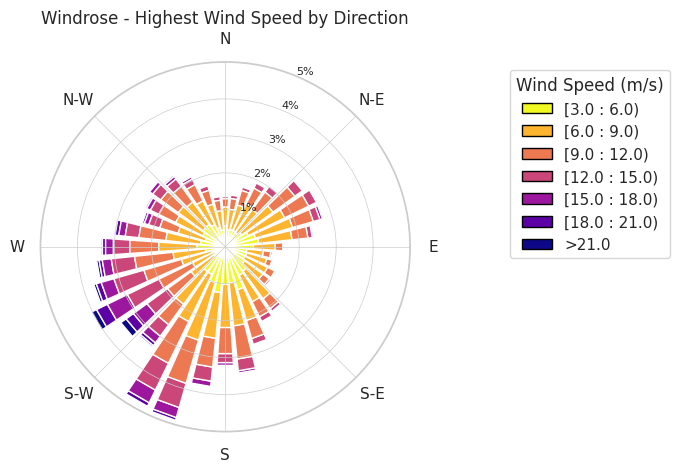

In [109]:
# Set Seaborn style
sns.set(style="whitegrid")

# Set up the windrose diagram
fig, ax = plt.subplots(subplot_kw={"projection": "windrose"})

# Plot the windrose
ax.bar(
    direction=knmi_weather_data["DD"],
    var=knmi_weather_data["FX_m/s"],
    nsector=36,
    bins=range(3, 24, 3),
    opening=0.8,
    cmap=plt.cm.plasma_r,
    normed=True,
)

# Customize the windrose plot
ax.set_title("Windrose - Highest Wind Speed by Direction")
ax.legend(title="Wind Speed (m/s)", bbox_to_anchor=(1.25, 1), loc="upper left")
ax.set_yticks(np.arange(1, 6))
ax.set_yticklabels([f"{p/100:.0%}" for p in percentages], fontsize=8)
ax.grid(True, linestyle="-", linewidth=0.5)

# Show the windrose plot
plt.show()

In [110]:
table = ax._info["table"]
wd_freq = np.sum(table, axis=0)
wd_freq

array([1.3733839 , 1.41870617, 1.71270455, 1.95839893, 2.06753018,
       2.61676447, 2.79268642, 2.75392395, 2.4223558 , 1.60774772,
       1.28631745, 1.35668623, 1.53797529, 1.53081914, 2.16831258,
       2.2810219 , 2.79089738, 3.44628119, 3.23756023, 3.85239254,
       4.91627308, 4.83815181, 3.35026955, 3.49339249, 4.02831449,
       3.70032441, 3.4987596 , 3.37233434, 3.03897715, 2.36629932,
       2.42772291, 2.58754353, 2.41221793, 2.13968799, 1.75683412,
       1.394256  ])